In [1]:
%pylab 
%matplotlib inline
import sympy
from control.matlab import *
from sympy import Poly
from sympy.abc import s, z
from IPython.display import display,Latex,Math
# Helper Functions
def tex(eqn,lhs=None):
    # Quick way to display a symbolic equation.
    if lhs == None:
        display(Math(sympy.latex(eqn)))
    
def sym_to_tf(sym_sys):
    # Convert a sympy symbolic equation into 
    # a control library transfer function.
    sym_num=sympy.Poly(sympy.numer(sym_sys),s)
    sym_den=sympy.Poly(sympy.denom(sym_sys),s)
    num = float64(sym_num.all_coeffs())
    den = float64(sym_den.all_coeffs())
    sys = tf(num,den)
    return sys

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


<div id="toc"></div>

# Introduction: Frequency Domain Methods for Controller Design

The frequency response method of controller design may be less intuitive than other methods you have studied previously.  However, it has certain advantages, especially in real-life situations such as modeling transfer functions from physical data.  In this tutorial, we will see how we can use the open-loop frequency response of a system to predict its behavior in closed-loop.

## Gain and Phase Margin

Consider the following unity feedback system:
![FrequencyResponseTutorial_BodePlots_Margins_BlockDiagram.png](figures/FrequencyResponseTutorial_BodePlots_Margins_BlockDiagram.png)
where \\(K\\) is a variable (constant) gain and \\(G(s)\\) is the plant under consideration.  The **gain margin** is defined as the change in open-loop gain required to make the system unstable.  Systems with greater gain margins can withstand greater changes in system parameters before becoming unstable in closed-loop. 

The **phase margin** is defined as the change in open-loop phase shift required to make a closed-loop system unstable. 

The phase margin also measures the system's tolerance to time delay.  If there is a time delay greater than \\(180/W_{pc}\\) in the loop (where \\(W_{pc}\\) is the frequency where the phase shift is 180 deg), the system will become unstable in closed-loop.  The time delay, \\(\tau_d\\) can be thought of as an extra block in the forward path of the block diagram that adds phase to the system but has no effect on the gain.  That is, a time delay can be represented as a block with magnitude of 1 and phase \\(\omega \tau_d\\) (in radians/second).

For now, we won't worry about where all this comes from and will concentrate on identifying the gain and phase margins on a Bode plot.

The phase margin is the difference in phase between the phase curve and -180 degrees at the point corresponding to the frequency that gives us a gain of 0 dB (the gain crossover frequency, $W_{gc}$).  Likewise, the gain margin is the difference between the magnitude curve and 0 dB at the point corresponding to the frequency that gives us a phase of -180 degrees (the phase crossover frequency, $W_{pc}$).

![FrequencyResponseTutorial_BodePlots_Margins_MarginDiagrams.png](figures/FrequencyResponseTutorial_BodePlots_Margins_MarginDiagrams.png)

One nice thing about the phase margin is that you don't need to replot the Bode in order to find the new phase margin when changing the gains. If you recall, adding gain only shifts the magnitude plot up.  This is equivalent to changing the y-axis on the magnitude plot.  Finding the phase margin is simply a matter of finding the new cross-over frequency and reading off the phase margin.  For example, suppose you entered the command ```bode(sys)```. You will get the following bode plot:

<IPython.core.display.Math object>

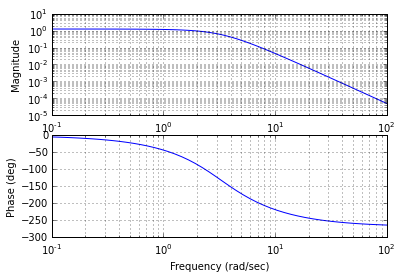

In [34]:
sym_sys = 50/(s**3 + 9*s**2 + 30*s +40);
tex(sym_sys)
sys = sym_to_tf(sym_sys)
mag, phase, omega = bode(sys, Plot=True)

You should see that the phase margin is about 100 degrees.  Now suppose you added a gain of 100, by entering the command ```bode(100*sys)```.  You should get the following plot:

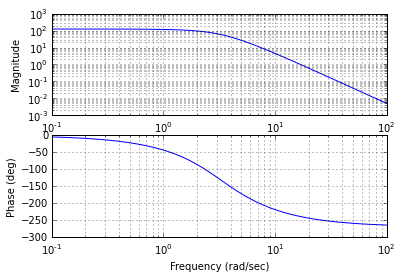

In [38]:
mag, phase, omega = bode(100*sys, Plot=True)

As you can see the phase plot is exactly the same as before, and the magnitude plot is shifted up by 40 dB (gain of 100).  The phase margin is now about -60 degrees.  This same result could be achieved if the y-axis of the magnitude plot was shifted down 40 dB.  Try this, look at the first Bode plot, find where the curve crosses the -40 dB line, and read off the phase margin.  It should be about 90 degrees, the same as the second Bode plot. 

We can calculate and display the gain and phase margins using the ```margin(sys)``` command. This command returns the gain and phase margins, the gain and phase cross over frequencies, and a graphical representation of these on the Bode plot.  Let's check it out:

In [12]:
margin(100*sys)

(0.045999999999999999,
 300.37439587506373,
 16.892606481091981,
 5.4772255750516612)

[Author's Tangent: We can make a function to make that easier to read and more verbose.]

In [55]:
def margin2(sys):
    gm, pm, Wcg, Wcp = margin(sys)
    gm_db = 20*numpy.log10(gm)
    # Sometimes this wrapps around.s
    if pm>0:
        pm = pm - 360
    tex(r"GM: "+"{:.2f} dB".format(gm_db))
    tex(r"\omega_{gm}: "+"{:.2f} rad/sec".format(Wcp))
    tex(r"PM: "+"{:.2f} ^o".format(pm))
    tex(r"\omega_{pm}: "+"{:.2f} rad/sec".format(Wcg))
margin2(100*sys)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Bandwidth Frequency

The bandwidth frequency is defined as the frequency at which the closed-loop magnitude response is equal to -3 dB.  However, when we design via frequency response, we are interested in predicting the closed-loop behavior from the open-loop response.  Therefore, we will use a second-order system approximation and say that the bandwidth frequency equals the frequency at which the open-loop magnitude response is between -6 and -7.5 dB, assuming the open-loop phase response is between -135 deg and -225 deg.  For a complete derivation of this approximation, consult your textbook.

In order to illustrate the importance of the bandwidth frequency, we will show how the output changes with different input frequencies.  We will find that sinusoidal inputs with frequency less than ``Wbw`` (the bandwidth frequency) are tracked "reasonably well" by the system.  Sinusoidal inputs with frequency greater than ``Wbw`` are attenuated (in magnitude) by a factor of 0.707 or greater (and are also shifted in phase). Let's say we have the following closed-loop transfer function representing a system:

$$
G(s) = \frac{1}{s^2 + 0.5s + 1}
$$

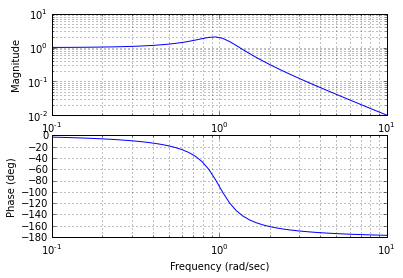

In [56]:
sym_sys = 1/(s**2 + 0.5*s + 1);
sys = sym_to_tf(sym_sys)
mag, phase, omega = bode(sys, Plot=True)

Since this is the closed-loop transfer function, our bandwidth frequency will be the frequency corresponding to a gain of -3 dB.  Looking at the plot, we find that it is approximately 1.4 rad/s.  We can also read off the plot that for an input frequency of 0.3 radians, the output sinusoid should have a magnitude about one and the phase should be shifted by perhaps a few degrees (behind the input).  For an input frequency of 3 rad/sec, the output magnitude should be about -20 dB (or 1/10 as large as the input) and the phase should be nearly -180 (almost exactly out-of-phase).  We can use the ```lsim``` command to simulate the response of the system to sinusoidal inputs. 

First, consider a sinusoidal input with a **frequency lower than ```Wbw```**. We must also keep in mind that we want to view the steady state response. Therefore, we will modify the axes in order to see the steady state response clearly (ignoring the transient response).

In [77]:
sym_sys = 1/(s**2 + 0.5*s + 1);
tex(sym_sys)
w = 0.3;
t = np.arange(0,100,0.1)
u = sin(w*t);

<IPython.core.display.Math object>

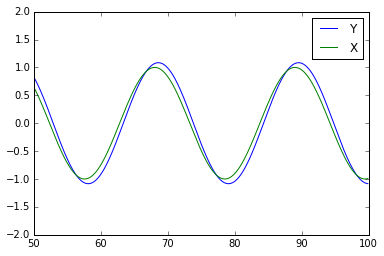

In [78]:
sys = sym_to_tf(sym_sys)
yout, T, ydot = lsim(sys, u, t)
p = plot(t,yout,t,u)
a = axis([50,100,-2,2])
l = legend(("Y","X"))

Note that the output (blue) tracks the input (green) fairly well; it is perhaps a few degrees behind the input as expected. However, if we set the frequency of the input **higher than the bandwidth frequency** for the system, we get a very distorted response (with respect to the input):

In [80]:
sym_sys = 1/(s**2 + 0.5*s + 1);
tex(sym_sys)
w = 3;
t = np.arange(0,100,0.1)
u = sin(w*t);

<IPython.core.display.Math object>

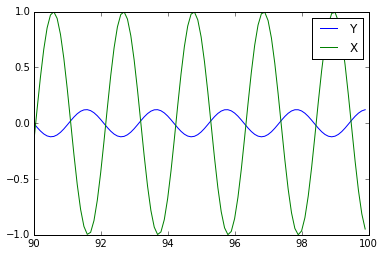

In [81]:
sys = sym_to_tf(sym_sys)
yout, T, xout = lsim(sys, u, t)
p = plot(t,yout,t,u)
l = legend(("Y","X"))
a = axis([90,100,-1,1])

Again, note that the magnitude is about 1/10 that of the input, as predicted, and that it is almost exactly out of phase (180 degrees behind) the input.  Feel free to experiment and view the response for several different frequencies $\omega$, and see if they match the Bode plot.

## Nyquist Diagram

The Nyquist plot allows us to predict the stability and performance of a closed-loop system by observing its open-loop behavior.  The Nyquist criterion can be used for design purposes regardless of open-loop stability (remember that the Bode design methods assume that the system is stable in open-loop).  Therefore, we use this criterion to determine closed-loop stability when the Bode plots display confusing information. 

The Nyquist diagram is basically a plot of \\(G(j\omega)\\) where \\(G(s)\\) is the open-loop transfer function and \\(\omega\\) is a vector of frequencies which encloses the entire right-half plane.  In drawing the Nyquist diagram, both positive and negative frequencies (from zero to infinity) are taken into account.  We will represent positive frequencies in red and negative frequencies in green.  The frequency vector used in plotting the Nyquist diagram usually looks like this (if you can imagine the plot stretching out to infinity):

![FrequencyResponseTutorial_NyquistDiagram_Block1.png](figures/FrequencyResponseTutorial_NyquistDiagram_Block1.png)

However, if we have open-loop poles or zeros on the jw axis, \\(G(s)\\) will not be defined at those points, and we must loop around them when we are plotting the contour.  Such a contour would look as follows:

![FrequencyResponseTutorial_NyquistDiagram_Block2.png](figures/FrequencyResponseTutorial_NyquistDiagram_Block2.png)

Please note that the contour loops around the pole on the jw axis.  As we mentioned before, the MATLAB |nyquist| command does not take poles or zeros on the jw axis into account and therefore produces an incorrect plot.  To correct this, please download and use <Content/Introduction/Control/Frequency/nyquist1.m nyquist1.m>.  If we have a pole on the jw axis, we have to use ```nyquist1```.

## The Cauchy Criterion

The Cauchy criterion (from complex analysis) states that when taking a closed contour in the complex plane, and mapping it through a complex function \\(G(s)\\), the number of times that the plot of \\(G(s)\\) encircles the origin is equal to the number of zeros of \\(G(s)\\) enclosed by the frequency contour minus the number of poles of \\(G(s)\\) enclosed by the frequency contour.  Encirclements of the origin are counted as positive if they are in the same direction as the original closed contour or negative if they are in the opposite direction. When studying feedback controls, we are not as interested in \\(G(s)\\) as in the closed-loop transfer function:

$$
\frac{G(s)}{1 + G(s)}
$$

**Note: The MATLAB nyquist command does not provide an adequate representation for systems that have open-loop poles in the jw-axis.**

**[Author has not evaluated if this holds true for Python's nyquist. If anyone has any systems to test open an issue]**

If \\(1 + G(s)\\) encircles the origin, then \\(G(s)\\) will enclose the point -1.  Since we are interested in the closed-loop stability, we want to know if there are any closed-loop poles (zeros of \\(1 + G(s)\\)) in the right-half plane.  More details on how to determine this will come later. Therefore, the behavior of the Nyquist diagram around the -1 point in the real axis is very important; however, the axis on the standard ```nyquist``` diagram might make it hard to see what's happening around this point. To view a simple Nyquist plot, we will define the following transfer function and view the Nyquist plot:

$$
\frac{0.5}{s - 0.5}
$$

In [ ]:
sym_sys = 0.5/(s - 0.5)
tex(sym_sys)

<IPython.core.display.Math object>

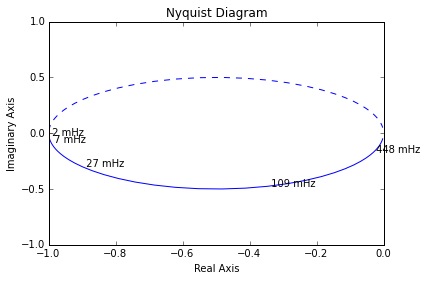

In [91]:
sys=sym_to_tf(sym_sys)
real, imag, freq = nyquist(sys, Plot=True, labelFreq=10)
a= axis([-1,0,-1,1])
xlabel('Real Axis')
ylabel('Imaginary Axis')
title('Nyquist Diagram')

Now we will look at the Nyquist diagram for the following transfer function:

$$
\frac{s + 2}{s^2}
$$

Note that this function has a pole at the origin.  We will see the difference between using the |nyquist|, |nyquist1|, and |lnyquist| commands with this particular function.

In [9]:
# sys = (s + 2)/(s^2);
# nyquist(sys)

In [10]:
# nyquist1(sys)

In [11]:
# lnyquist(sys)

Note that the |nyquist| plot is not the correct one, the |nyquist1| plot is correct, but it's hard to see what happens close to the -1 point, and the |lnyquist| plot is correct and has an appropriate scale.

## Closed-Loop Performance from Bode Plots

In order to predict closed-loop performance from open-loop frequency response, we need to have several concepts clear:
* The system must be stable in open-loop if we are going to design via Bode plots.
** If the **gain crossover frequency** is less than the **phase crossover frequency* (i.e. $W_{gc} < W_{pc}$), then the closed-loop system will be stable.
* For second-order systems, the closed-loop damping ratio is approximately equal to the phase margin divided by 100 if the phase margin is between 0 and 60 degrees.  We can use this concept with caution if the phase margin is greater than 60 degrees.
* For second-order systems, a relationship between damping ratio, bandwidth frequency, and settling time is given by an equation described on the [Extras: Bandwidth](../Extras_wbw.ipynb) page.
* A very rough estimate that you can use is that the bandwidth is approximately equal to the natural frequency. Let's use these concepts to design a controller for the following system:
![FrequencyResponseTutorial_BodePlots_CLPerformance_BlockDiagram.png](figures/FrequencyResponseTutorial_BodePlots_CLPerformance_BlockDiagram.png)
Where \\(G_c(s)\\) is the controller and \\(G(s)\\) is:

$$
G(s) = \frac{10}{1.25s + 1}
$$

The design must meet the following specifications:
* Zero steady state error.
* Maximum overshoot must be less than 40%.
* Settling time must be less than 2 seconds. There are two ways of solving this problem: one is graphical and the other is numerical.  Within MATLAB, the graphical approach is best, so that is the approach we will use.  First, let's look at the Bode plot. Create a |m-file| with the following code:

In [12]:
# sys = 10/(1.25*s + 1);
# bode(sys)

There are several characteristics of the system that can be read directly from this Bode plot.  First of all, we can see that the bandwidth frequency is around 10 rad/sec.  Since the bandwidth frequency is roughly the same as the natural frequency (for a first order system of this type), the rise time is |1.8/BW = 1.8/10 = 1.8 seconds|.  This is a rough estimate, so we will say the rise time is about 2 seconds. The phase margin for this system is approximately 95 degrees.  The relation |damping ratio = PM/100| only holds for |PM < 60|.  Since the system is first-order, there should be no overshoot. The last major point of interest is **steady-state error**. The steady-state error can be read directly off the Bode plot as well.  The constant ($K_p$, $K_v$, or $K_a$) is found from the intersection of the low frequency asymptote with the |w = 1| line.  Just extend the low frequency line to the |w = 1| line.  The magnitude at this point is the constant. Since the Bode plot of this system is a horizontal line at low frequencies (slope = 0), we know this system is of type zero.  Therefore, the intersection is easy to find.  The gain is 20 dB (magnitude 10). What this means is that the constant for the error function is 10.  The steady-state error is |1/(1+Kp) = 1/(1+10) = 0.091|. If our system was type one instead of type zero, the constant for the steady-state error would be found in a manner similar to the following.
![FrequencyResponseTutorial_BodePlots_CLPerformance_Block2.png](figures/FrequencyResponseTutorial_BodePlots_CLPerformance_Block2.png)
Let's check our predictions by looking at a step response plot.  This can be done by adding the following two lines of code into the MATLAB command window.

In [13]:
# sys_cl = feedback(sys,1);
# step(sys_cl)
# title('Closed-Loop Step Response, No Controller')

As you can see, our predictions were very good.  The system has a rise time of about 2 seconds, has no overshoot, and has a steady-state error of about 9%.  Now we need to choose a controller that will allow us to meet the design criteria.  We choose a PI controller because it will yield zero steady-state error for a step input.  Also, the PI controller has a zero, which we can place.  This gives us additional design flexibility to help us meet our criteria.  Recall that a PI controller is given by:

$$
G_c(s) = \frac{K(s + a)}{s}
$$

The first thing we need to find is the damping ratio corresponding to a percent overshoot of 40%.  Plugging in this value into the equation relating overshoot and damping ratio (or consulting a plot of this relation), we find that the damping ratio corresponding to this overshoot is approximately 0.28.  Therefore, our phase margin should be at least 30 degrees. We must have a bandwidth frequency greater than or equal to 12 if we want our settling time to be less than 1.75 seconds which meets the design specs. Now that we know our desired phase margin and bandwidth frequency, we can start our design.  Remember that we are looking at the open-loop Bode plots.  Therefore, our bandwidth frequency will be the frequency corresponding to a gain of approximately -7 dB. Let's see how the integrator portion of the PI or affects our response. Change your |m-file| to look like the following (this adds an integral term but no proportional term):

In [14]:
# plant = 10/(1.25*s + 1);
# contr = 1/s;
# bode(contr*plant, logspace(0,2))

Our phase margin and bandwidth frequency are too small.  We will add gain and phase with a zero.  Let's place the zero at 1 for now and see what happens.  Change your |m-file| to look like the following:

In [15]:
# plant = 10/(1.25*s + 1);
# contr = (s + 1)/s;
# bode(contr*plant, logspace(0,2))

It turns out that the zero at 1 with a unit gain gives us a satisfactory answer.  Our phase margin is greater than 60 degrees (even less overshoot than expected) and our bandwidth frequency is approximately 11 rad/s, which will give us a satisfactory response.  Although satisfactory, the response is not quite as good as we would like.  Therefore, let's try to get a higher bandwidth frequency without changing the phase margin too much.  Let's try to increase the gain to 5 and see what happens.  This will make the gain shift and the phase will remain the same.

In [16]:
# plant = 10/(1.25*s + 1);
# contr = 5 * ((s + 1)/s);
# bode(contr*plant, logspace(0,2))

That looks really good.  Let's look at our step response and verify our results.  Add the following two lines to your |m-file|:

In [17]:
# sys_cl = feedback(contr*plant,1);
# step(sys_cl)

As you can see, our response is better than we had hoped for.  However, we are not always quite as lucky and usually have to play around with the gain and the position of the poles and/or zeros in order to achieve our design requirements.

## Closed-Loop Stability from the Nyquist Diagram

Consider the negative feedback system:
![FrequencyResponseTutorial_NyquistDiagram_CLStability_Block1.png](figures/FrequencyResponseTutorial_NyquistDiagram_CLStability_Block1.png)
Remember from the Cauchy criterion that the number |N| of times that the plot of |G(s)H(s)| encircles -1 is equal to the number |Z| of zeros of |1 + G(s)H(s)| enclosed by the frequency contour minus the number |P| of poles of |1 + G(s)H(s)| enclosed by the frequency contour |(N = Z - P)|. Keeping careful track of open- and closed-loop transfer functions, as well as numerators and denominators, you should convince yourself that:
* The zeros of |1 + G(s)H(s)| are the poles of the closed-loop transfer function.
* The poles of |1 + G(s)H(s)| are the poles of the open-loop transfer function. The Nyquist criterion then states that:
* |P| = the number of open-loop (unstable) poles of |G(s)H(s)|.
* |N| = the number of times the Nyquist diagram encircles -1.
* clockwise encirclements of -1 count as positive encirclements.
* counter-clockwise encirclements of -1 count as negative encirclements.
* |Z| = the number of right-half-plane (positive, real) poles of the closed-loop system. The important equation whih relates these three quantities is:

$$
Z = P + N
$$

*Note: This is only one convention for the Nyquist criterion. Another convention states that a positive |N| counts the counter-clockwise or anti-clockwise encirclements of -1.  The |P| and |Z| variables remain the same.  In this case the equation becomes |Z = P - N|.  Throughout these tutorials, we will use a positive sign for clockwise encirclements.* It is very important (and somewhat tricky) to learn how to count the number of times that the diagram encircles -1.  Therefore, we will go into some detail to help you visualize this.  You can view this **movie** as an example. Another way of looking at it is to imagine you are standing on top of the -1 point and are following the diagram from beginning to end.  Now ask yourself: How many times did I turn my head a full 360 degrees?  Again, if the motion was clockwise, |N| is positive, and if the motion is anti-clockwise, |N| is negative. Knowing the number of right-half plane (unstable) poles in open loop (|P|), and the number of encirclements of -1 made by the Nyquist diagram (|N|), we can determine the closed-loop stability of the system.  If |Z = P + N| is a positive, nonzero number, the closed-loop system is unstable. We can also use the Nyquist diagram to find the range of gains for a closed-loop unity feedback system to be stable.  The system we will test looks like this:
![FrequencyResponseTutorial_NyquistDiagram_CLStability_Block2.png](figures/FrequencyResponseTutorial_NyquistDiagram_CLStability_Block2.png)
where G(s) is:

$$
\frac{s^2 + 10s + 24}{s^2 - 8s + 15}
$$

This system has a gain |K| which can be varied in order to modify the response of the closed-loop system.  However, we will see that we can only vary this gain within certain limits, since we have to make sure that our closed-loop system will be stable.  This is what we will be looking for: the range of gains that will make this system stable in the closed-loop. The first thing we need to do is find the number of positive real poles in our open-loop transfer function:

In [18]:
# roots([1 -8 15])

The poles of the open-loop transfer function are both positive. Therefore, we need two anti-clockwise (|N = -2|) encirclements of the Nyquist diagram in order to have a stable closed-loop system (|Z = P + N|).  If the number of encirclements is less than two or the encirclements are not anti-clockwise, our system will be unstable. Let's look at our Nyquist diagram for a gain of 1:

In [19]:
# sys = (s^2 + 10*s + 24)/(s^2 - 8*s + 15);
# nyquist(sys)

There are two anti-clockwise encirclements of -1.  Therefore, the system is stable for a gain of 1.  Now we will see how the system behaves if we increase the gain to 20:

In [20]:
# nyquist(20*sys)

The diagram expanded.  Therefore, we know that the system will be stable no matter how much we increase the gain.  However, if we decrease the gain, the diagram will contract and the system might become unstable. Let's see what happens for a gain of 0.5:

In [21]:
# nyquist(0.5*sys)

The system is now unstable.  By trial and error we find that this system will become unstable for gains less than 0.80.  We can verify our answers by zooming in on the Nyquist plots as well as by looking at the closed-loop steps responses for gains of 0.79, 0.80, and 0.81. **Gain Margin** We already defined the gain margin as the change in open-loop gain expressed in decibels (dB), required at 180 degrees of phase shift to make the system unstable.  Now we are going to find out where this comes from.  First of all, let's say that we have a system that is stable if there are no Nyquist encirclements of -1, such as:

$$
\frac{50}{s^3 + 9s^2 + 30s + 40}
$$

Looking at the roots, we find that we have no open loop poles in the right half plane and therefore no closed-loop poles in the right-half-plane if there are no Nyquist encirclements of -1.  Now, how much can we vary the gain before this system becomes unstable in closed-loop?  Let's look at the following figure:
![FrequencyResponseTutorial_NyquistDiagram_GainMargin_Block1.png](figures/FrequencyResponseTutorial_NyquistDiagram_GainMargin_Block1.png)
The open-loop system represented by this plot will become unstable in closed loop if the gain is increased past a certain boundary.  The negative real axis area between |-1/a| (defined as the point where the 180 degree phase shift occurs...that is, where the diagram crosses the real axis) and -1 represents the amount of increase in gain that can be tolerated before closed-loop instability. If we think about it, we realize that if the gain is equal to |a|, the diagram will touch the -1 point:

$$
G(jw) = \frac{-1}{a}
$$

or

$$
aG(jw) = -1
$$

Therefore, we say that the gain margin is |a| units.  However, we mentioned before that the gain margin is usually measured in decibels. Hence, the gain margin is:

$$
GM = 20log_{10}(a) [dB]
$$

We will now find the gain margin of the stable, open-loop transfer function we viewed before.  Recall that the function is:

$$
\frac{50}{s^3 + 9s^2 + 30s + 40}
$$

and that the Nyquist diagram can be viewed by typing:

In [22]:
# sys = 50/(s^3 + 9*s^2 + 30*s + 20);
# nyquist(sys)

As we discussed before, all that we need to do to find the gain margin is find |a|, as defined in the preceding figure.  To do this, we need to find the point where there is exactly 180 degrees of phase shift.  This means that the transfer function at this point is real (has no imaginary part).  The numerator is already real, so we just need to look at the denominator.  When |s = jw|, the only terms in the denominator that will have imaginary parts are those which are odd powers of |s|.  Therefore, for |G(jw)| to be real, we must have:

$$
-jw^3 + 30jw = 0
$$

which means |w = 0| (this is the rightmost point in the Nyquist diagram) or |w = sqrt(30)|.  We can then find the value of |G(jw)| at this point using |polyval|:

In [23]:
# w = sqrt(30);
# polyval(50,j*w)/polyval([1 9 30 40],j*w)

The answer is: |-0.2174 + 0i|.  The imaginary part is zero, so we know that our answer is correct.  We can also verify by looking at the Nyquist plot again.  The real part also makes sense.  Now we can proceed to find the gain margin. We found that the 180 degrees phase shift occurs at |-0.2174 + 0i|.  This point was previously defined as |-1/a|.  Therefore, we now have |a|, which is the gain margin.  However, we need to express the gain margin in decibels:

$$
\frac{-1}{a} = -0.2174
$$



$$
=> a = 4.6
$$



$$
=> GM = 20log_{10}(4.6) = 13.26 dB
$$

We now have our gain margin.  Let's see how accurate it is by using a gain of |a = 4.6| and zooming in on the Nyquist plot:

In [24]:
# a = 4.6;
# nyquist(a*sys)

In [25]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>